In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray
import os

In [2]:
data = pd.read_csv('fer2013.csv')

In [3]:
output_label = ['Anger','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [4]:
print("Unique labels:",len(np.unique(np.array(data['emotion']))))
print("Pixel Type:",type(data['pixels'][2]))
data.tail(5)

Unique labels: 7
Pixel Type: <class 'str'>


,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


<AxesSubplot:xlabel='emotion', ylabel='count'>

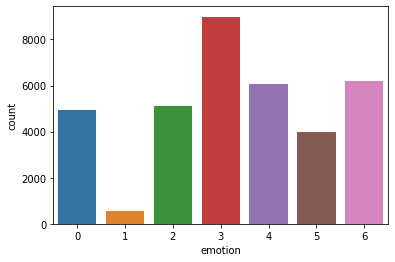

In [5]:
# number of Sample per label
sns.countplot(x=data['emotion'], data = data)

In [6]:
# Convertion of df['Pixel'] into array and reshape
def string2array(x):
    return np.array(x.split(' ')).reshape(48,48,1).astype('float32')

In [7]:
X = data['pixels'].apply(lambda x : string2array(x))
X = np.array(X)
X=np.stack(X,axis=0)
X=X/255
y=np.array(data['emotion'])

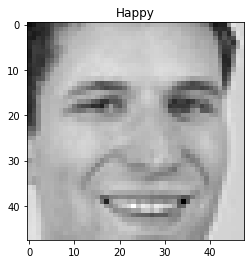

In [8]:
# Sample Image
img_no = 1246
img = X[img_no].reshape(48,48)
plt.figure()
plt.title(output_label[y[img_no]])
plt.imshow(img,cmap='gray')

In [9]:
# Convet Numpy array to categorical 
from keras.utils.np_utils import to_categorical

In [10]:
y = to_categorical(y)
print(X.shape,y.shape)

(35887, 48, 48, 1) (35887, 7)


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.25,shuffle=True)

In [12]:
print(X_train.shape,Y_train.shape)

(26915, 48, 48, 1) (26915, 7)


In [13]:
print(X_test.shape,Y_test.shape)

(8972, 48, 48, 1) (8972, 7)


# Model Training

In [14]:
from keras.layers import Dense,Flatten,Dropout,MaxPooling2D,Conv2D,Activation
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [15]:
num_classes = 7
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64,(4,4),activation='relu',padding='same'))
model.add(Conv2D(64,(5,5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(4,4),activation='relu',padding='same'))
model.add(Conv2D(128,(5,5),activation='relu',padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [16]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    validation_split = 0.25,
    fill_mode="nearest")

In [17]:
model.fit(aug.flow(X_train, Y_train, batch_size=64),
            epochs=1, 
            verbose=1, 
            shuffle=True,
            )

421/421 [==============================] - 1248s 3s/step - loss: 1.8257 - accuracy: 0.2677


In [19]:
preds = model.predict(X_test, verbose=1)

281/281 [==============================] - 116s 411ms/step


In [22]:
#model performance evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy score: ",accuracy_score(Y_test, np.round_(preds)))
print("Classification report:")
print(classification_report(Y_test, np.round_(preds)))

Accuracy score:  0.06018724921979492
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1220
           1       0.00      0.00      0.00       152
           2       0.00      0.00      0.00      1299
           3       0.36      0.23      0.28      2292
           4       0.40      0.00      0.01      1488
           5       0.00      0.00      0.00      1006
           6       0.00      0.00      0.00      1515

   micro avg       0.36      0.06      0.10      8972
   macro avg       0.11      0.03      0.04      8972
weighted avg       0.16      0.06      0.07      8972
 samples avg       0.06      0.06      0.06      8972



C:\Users\devan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\devan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


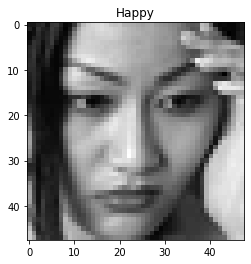

In [24]:
#sample image
img_no = 6 #image number range(0,8972)
img = X_test[img_no].reshape(48,48)
plt.figure()
plt.title(output_label[np.argmax(preds[img_no])])
plt.imshow(img, cmap='gray')

In [25]:
# Model is not trained well becasue of slow Jupyter notebook